<a href="https://colab.research.google.com/github/Rahullnitp/EDA_Loan_Defaulter/blob/master/Repayer_vs_Defaulter_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Many people struggle to get loans due to insufficient or non-existent credit histories. And, unfortunately, this population is often taken advantage of by untrustworthy lenders .                          
###companies have been using predictive analytics for quite a long time that identifies a bad applicant who is more likely to be charged off.In this notebook, I will build a model that for the exploratory analysis of all the feature and create a predictive loan model by using algorithms like LOGISTIC REGRESION , RANDOM FOREST and LightGBM.


In [0]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import  Image    #Python image ibrary
%matplotlib inline
import pandas as pd
import seaborn as sns
import itertools
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split  # for splitting the dataset into train and test set.
from sklearn.preprocessing import StandardScaler      # for standardisation of dataset .
from sklearn.metrics import recall_score, roc_auc_score, f1_score
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix

# 1. Data upload and pre-processing

In [0]:
from google.colab import files
uploaded=files.upload()

Saving Loan.csv to Loan.csv


In [0]:
Data=pd.read_csv("Loan.csv")   #reading the data

In [0]:
Data.head()   #displaying top 5 rows of data

,s,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,...,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,1077501,1296599,5000,5000,4975.0,36 months,10.65%,162.87,B,B2,NaN,10+ years,RENT,24000.0,Verified,12/11,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/22/11 > I need to upgra...,credit_card,Computer,860xx,AZ,27.65,0,01/85,1,NaN,NaN,3,0,13648,83.70%,9,f,0.00,0.00,5863.155187,5833.84,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
1,1077430,1314167,2500,2500,2500.0,60 months,15.27%,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,12/11,Charged Off,n,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/22/11 > I plan to use t...,car,bike,309xx,GA,1.00,0,04/99,5,NaN,NaN,3,0,1687,9.40%,4,f,0.00,0.00,1008.710000,1008.71,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
2,1077175,1313524,2400,2400,2400.0,36 months,15.96%,84.33,C,C5,NaN,10+ years,RENT,12252.0,Not Verified,12/11,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,small_business,real estate business,606xx,IL,8.72,0,11/01,2,NaN,NaN,2,0,2956,98.50%,10,f,0.00,0.00,3005.666844,3005.67,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
3,1076863,1277178,10000,10000,10000.0,36 months,13.49%,339.31,C,C1,AIR RESOURCES BOARD,10+ years,RENT,49200.0,Source Verified,12/11,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/21/11 > to pay for prop...,other,personel,917xx,CA,20.00,0,02/96,1,35.0,NaN,10,0,5598,21%,37,f,0.00,0.00,12231.890000,12231.89,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
4,1075358,1311748,3000,3000,3000.0,60 months,12.69%,67.79,B,B5,University Medical Group,1 year,RENT,80000.0,Source Verified,12/11,Current,n,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/21/11 > I plan on combi...,other,Personal,972xx,OR,17.94,0,01/96,0,38.0,NaN,15,0,27783,53.90%,38,f,524.06,524.06,3513.330000,3513.33,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN


In [0]:
Data.loan_status.value_counts() # loan status

Fully Paid     32950
Charged Off     5627
Current         1140
Name: loan_status, dtype: int64

These are three types of loan status , where ' charged off ' applicants are defaulter which i have to predict.

The applicant with label ' Current ' is in the process of paying the amount.so, they will not consider   as defaulter.

So, i will group ' Fully Paid '  and  '  Current  ' as 'Creditor'
 and ' Charged off ' as 'Defaulter'.

In [0]:
Data.loan_status=Data.loan_status.map(lambda x : 'Defaulter' if x== 'Charged Off' else 'Creditor')

In [0]:
print("data_shape:",Data.shape)

data_shape: (39717, 111)


# 2. Data cleaning and Feature analysis

Text(0.5, 1.0, '%_Missing_Data')

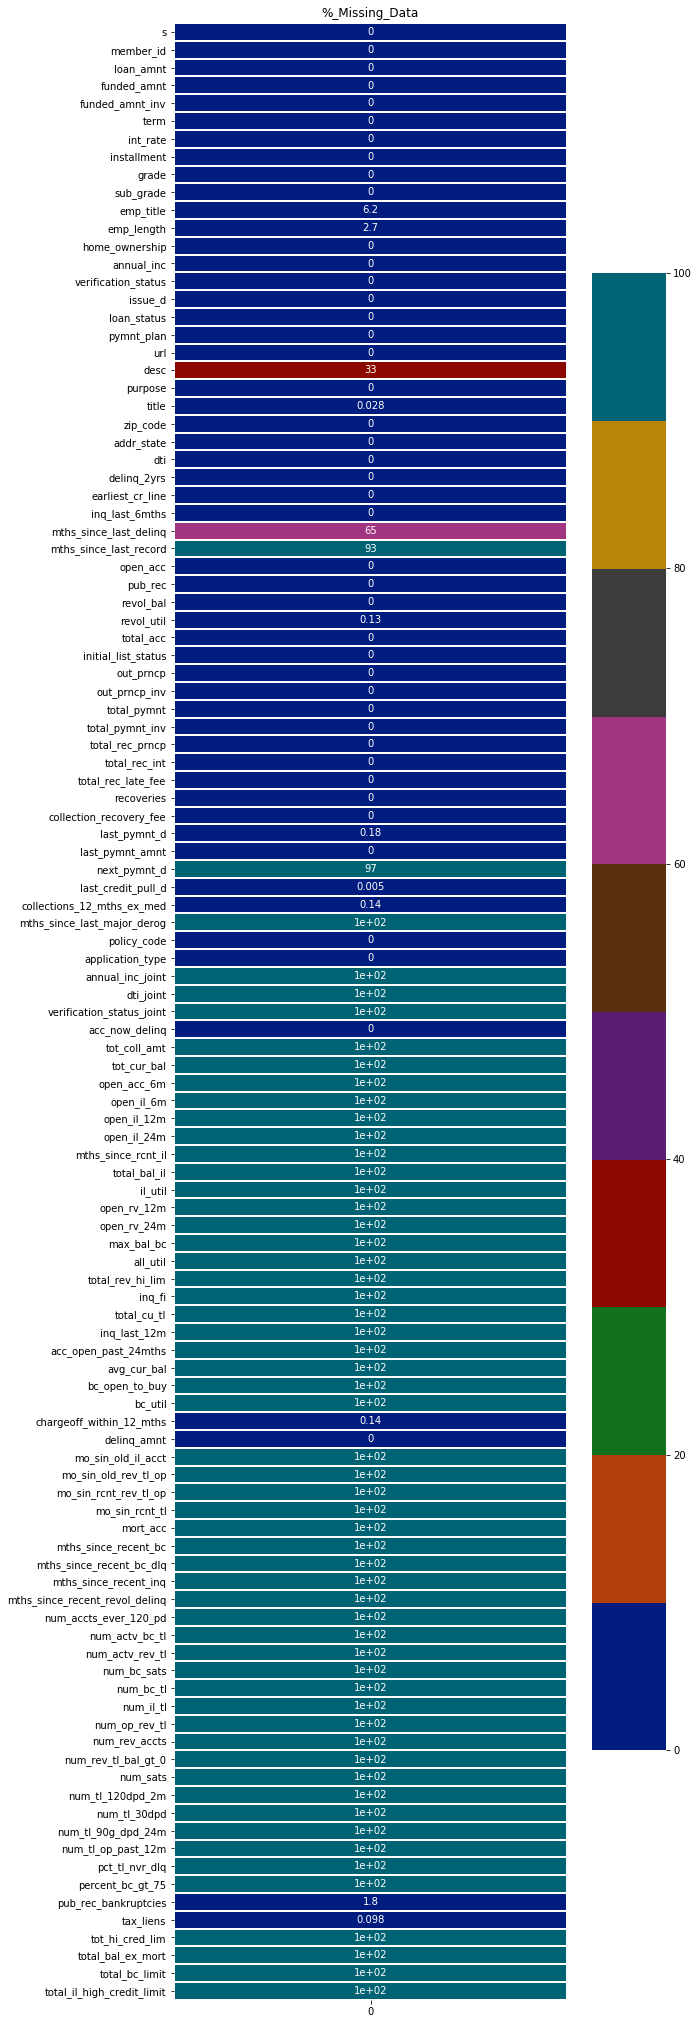

In [0]:
#PERCENTAGE OF DATA MISSING IN THE DATASET
plt.figure(figsize=(30,80))
plt.subplot(234)
sns.heatmap(pd.DataFrame((Data.isnull().sum()*100)/Data.shape[0]),annot=True,cmap=sns.color_palette("dark"),linewidths=1,linecolor="white")
plt.title("%_Missing_Data")

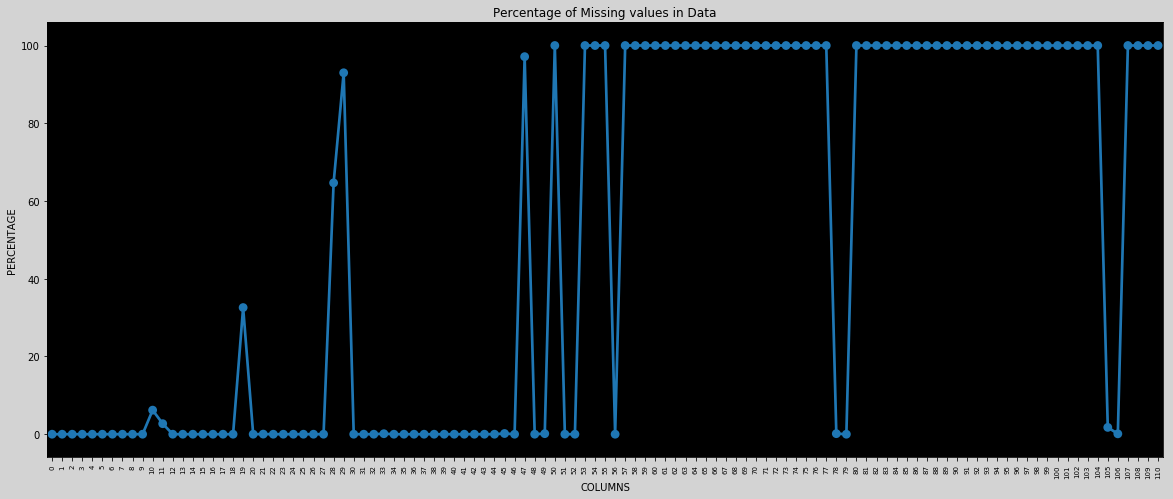

In [0]:
fig=plt.figure(figsize=(20,8))
miss_data=pd.DataFrame((Data.isnull().sum())*100/Data.shape[0]).reset_index()
ax = sns.pointplot(miss_data.index,0,data=miss_data)
plt.xticks(rotation =90,fontsize =7)
plt.title("Percentage of Missing values in Data")
plt.ylabel("PERCENTAGE")
plt.xlabel("COLUMNS")
ax.set_facecolor("k")
fig.set_facecolor("lightgrey")

       1.REMOVE FEATURES WHICH HAVE LOTS OF MISSING VALUES

In [0]:

# Columns which have lots of missing vales are useless for data analysis
# so, exclude the columns which have lots (MORE THAN 75%) missing values.

Data=Data.dropna(thresh=((.25)*len(Data)),axis=1)

In [0]:
#now,the shape of data:
Data.shape

(39717, 55)

      2.REMOVE THE FEATURES HAVING UNIQUE VALUES                          

In [0]:
Data = Data[[col for col in Data if not len(set(Data[col]))==1]]

In [0]:
Data.shape

(39717, 49)

     3. REMOVE THE FEATURES HAVING SAME VALUES IN MULTIPLE FEATURES WITH SAME OR DIFFERENT NAME (DUPLICATE COLUMNS)


In [0]:
Data=Data.T.drop_duplicates().T  #  remove the columns with same values

In [0]:
Data = Data.loc[:,~Data.columns.duplicated()]  # drop the columns with same name

In [0]:
Data.shape

(39717, 48)

       4. DROP THE DUPLICATE ROWS
           i.e. repetition of same example

In [0]:
Data.drop_duplicates(inplace=True)

In [0]:
Data.loc[0]

s                                                                       1077501
member_id                                                               1296599
loan_amnt                                                                  5000
funded_amnt                                                                5000
funded_amnt_inv                                                            4975
term                                                                  36 months
int_rate                                                                 10.65%
installment                                                              162.87
grade                                                                         B
sub_grade                                                                    B2
emp_title                                                                   NaN
emp_length                                                            10+ years
home_ownership                          

In [0]:
Data.shape

(39717, 48)

#                    ANALYSIS OF  EVERY FEATURE
    ## To get the most usefull feature we have to analyze each and every feature.    
    
    ##Before examine every feature , we need to make a plot function for visualization.

In [0]:
# function for plotting feature with and without loan status
def plt_feature(column,cont):
  
   #column - name of the column which you want to visualise
   #cont - wheter the feature is continuos or not
  
  fig,(ax1,ax2)=plt.subplots(nrows=1, ncols=2, figsize=(15,5),dpi=90)
  
  #-----PLOT WITHOUT LOAN STATUS-----
  
  if cont:
    #univariate distribution of observation
    sns.distplot(Data.loc[Data[column].notnull(), column], kde=False, ax=ax1)
  else:
    #Show the counts of observations in each categorical bin using bars.
    sns.countplot(Data[column], order=sorted(Data[column].unique()), color='#5975A4', saturation=1, ax=ax1)
  ax1.set_xlabel(column)
  ax1.set_ylabel('Count')
  ax1.set_title(column)
  plt.xticks(rotation = 90)
    
 #-----PLOT WITH LOAN STATUS------
  if cont:
    #show distributions with respect to categories.
        sns.boxplot(x=column, y='loan_status', data=Data, ax=ax2)
        ax2.set_ylabel('')
        ax2.set_title(column + ' by Loan Status')
  else:
        data1 = Data.groupby(column)['loan_status'].value_counts(normalize=True).to_frame('proportion').reset_index()        
        sns.barplot(x = column, y = 'proportion', hue= "loan_status", data = data1, saturation=1, ax=ax2)
        ax2.set_ylabel('Loan fraction')
        ax2.set_title('Loan status')
        plt.xticks(rotation = 90)
  ax2.set_xlabel(column)
    
  plt.tight_layout()
#

## VISUALISE FEATURES FROM  INDEX (0-6):

In [0]:
# Firstly we will create a list i.e. Remove_Feature which create the list of feature that we have to remove from Data.

Remove_Feature=[]


In [0]:
Data.iloc[0:5,0:7]

,s,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate
0,1077501,1296599,5000,5000,4975,36 months,10.65%
1,1077430,1314167,2500,2500,2500,60 months,15.27%
2,1077175,1313524,2400,2400,2400,36 months,15.96%
3,1076863,1277178,10000,10000,10000,36 months,13.49%
4,1075358,1311748,3000,3000,3000,60 months,12.69%


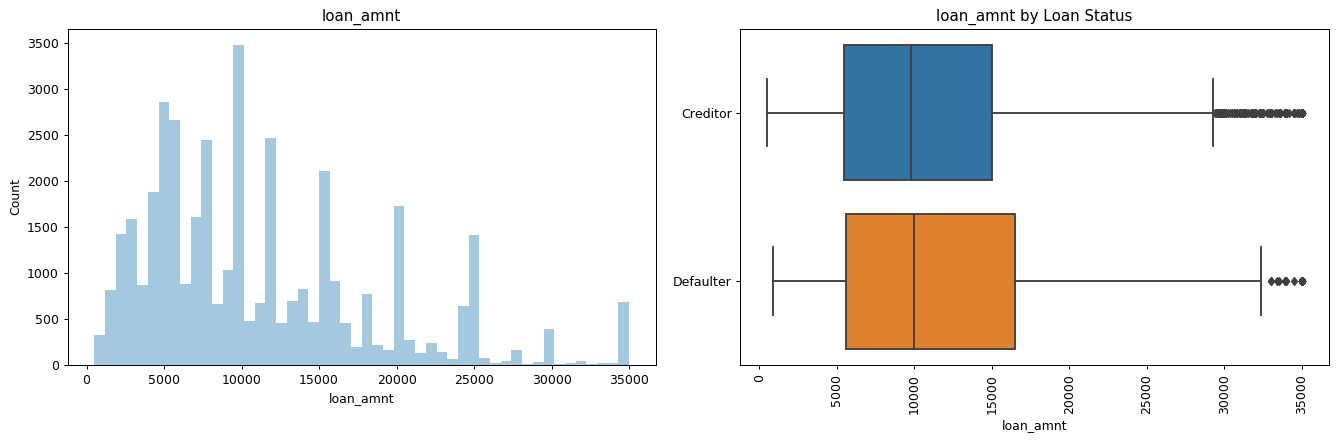

In [0]:
# FEATURE : loan_amnt

Data['loan_amnt']=Data['loan_amnt'].astype(float)  #convert the datatype from object to float
plt_feature('loan_amnt', True)

All loans are not unique,same amnt appear several times.
it means company lend certain range of money to the customer.
'funded_amnt' and ' funded_amnt_inv' have almost same feature as  'loan_amnt',we will keep them for now.

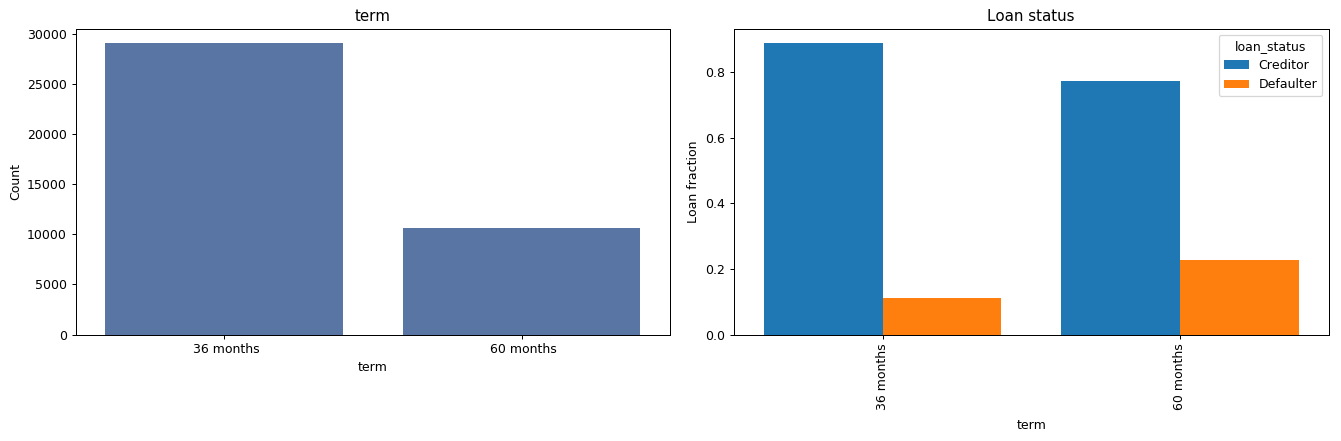

In [0]:
# Feature : term

plt_feature('term', False)

Loans for Longer term have more chances to get charged off

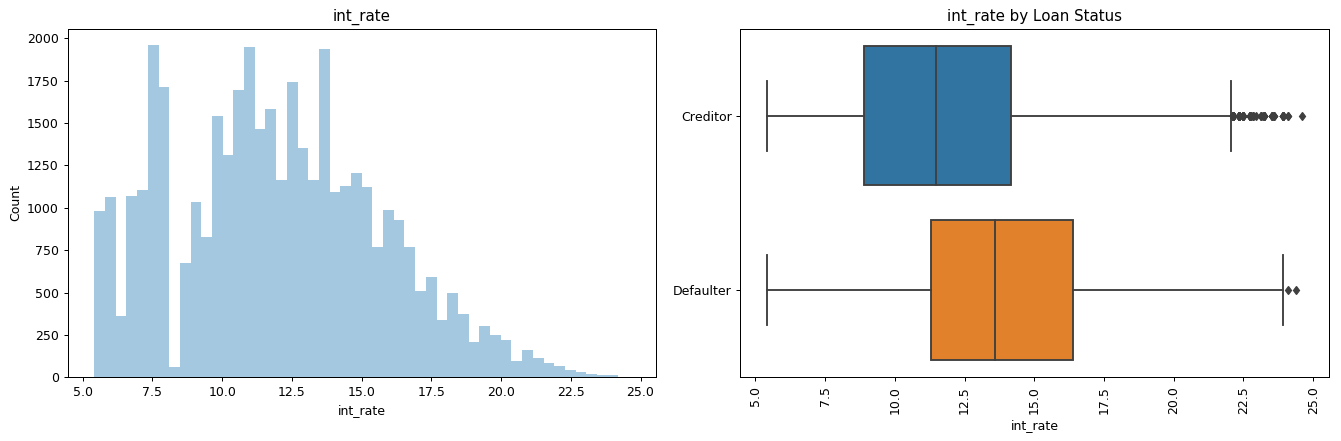

In [0]:
# Feature: int_rate
Data['int_rate'] = Data['int_rate'].astype(str).str.replace('%', '').astype(np.float32)
plt_feature('int_rate',True)

from the plot , those who were charged off had to pay a higher interest.

      #  As the 'member_id' feature has noothing to do with loan status as it is unique for each applicant .
      
  

In [0]:
Remove_Feature.extend(['member_id'])

## VISUALISE FEATURES FROM  INDEX (7-13):

In [0]:
Data.iloc[0:5, 7: 14]

,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc
0,162.87,B,B2,NaN,10+ years,RENT,24000
1,59.83,C,C4,Ryder,< 1 year,RENT,30000
2,84.33,C,C5,NaN,10+ years,RENT,12252
3,339.31,C,C1,AIR RESOURCES BOARD,10+ years,RENT,49200
4,67.79,B,B5,University Medical Group,1 year,RENT,80000


In [0]:
# Feature: grade and subgrade
Data['grade'].value_counts()

B    12020
A    10085
C     8098
D     5307
E     2842
F     1049
G      316
Name: grade, dtype: int64

In [0]:
Data['sub_grade'].value_counts()

B3    2917
A4    2886
A5    2742
B5    2704
B4    2512
C1    2136
B2    2057
C2    2011
B1    1830
A3    1810
C3    1529
A2    1508
D2    1348
C4    1236
C5    1186
D3    1173
A1    1139
D4     981
D1     931
D5     874
E1     763
E2     656
E3     553
E4     454
E5     416
F1     329
F2     249
F3     185
F4     168
F5     118
G1     104
G2      78
G4      56
G3      48
G5      30
Name: sub_grade, dtype: int64

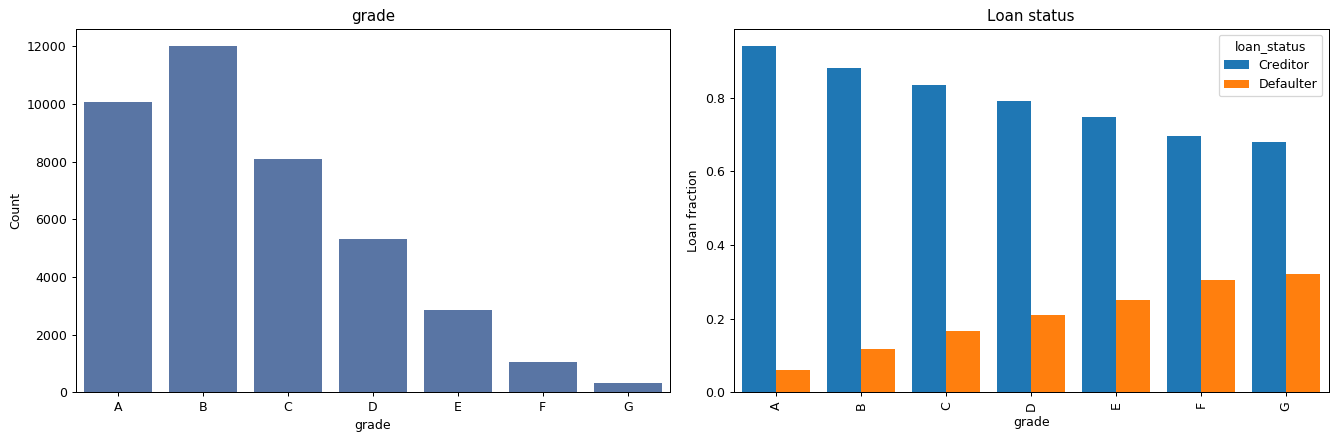

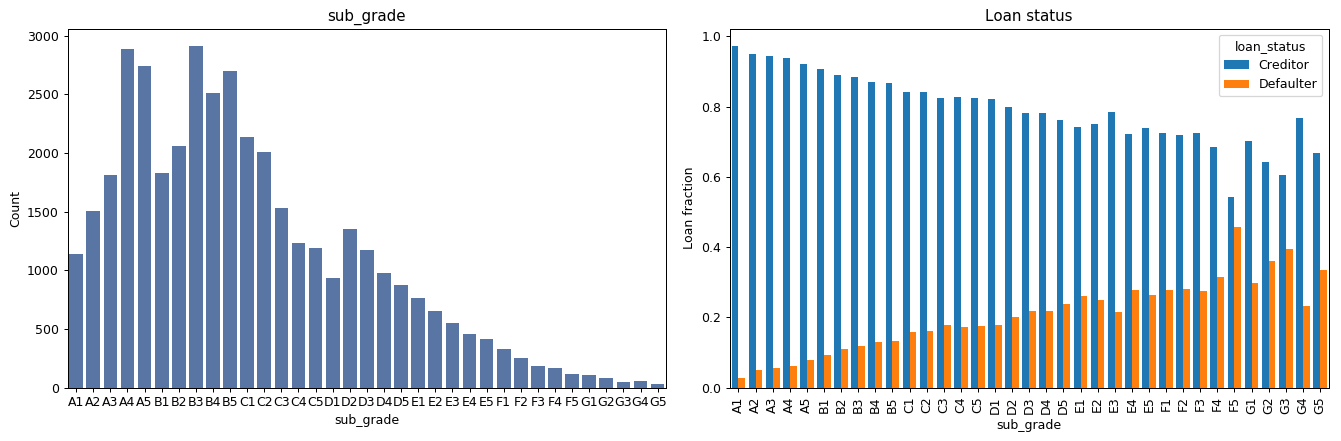

In [0]:
plt_feature('grade', False)
plt_feature('sub_grade', False)

From the plot , it seems like grade and sub_grade is closely related.so , i will keep one (sub_grade as it contain more information) the two .

In [0]:
#Feature: emp_title

len(Data.emp_title.value_counts())

28820

More than 75% of data have the unique value and hence it will not contribute that much to the analysis.
so, i will not consider it.

In [0]:
# Feature: emp_length

len(Data.emp_length.value_counts())


11

In [0]:
Data.emp_length.value_counts()

10+ years    8879
< 1 year     4583
2 years      4388
3 years      4095
4 years      3436
5 years      3282
1 year       3240
6 years      2229
7 years      1773
8 years      1479
9 years      1258
Name: emp_length, dtype: int64

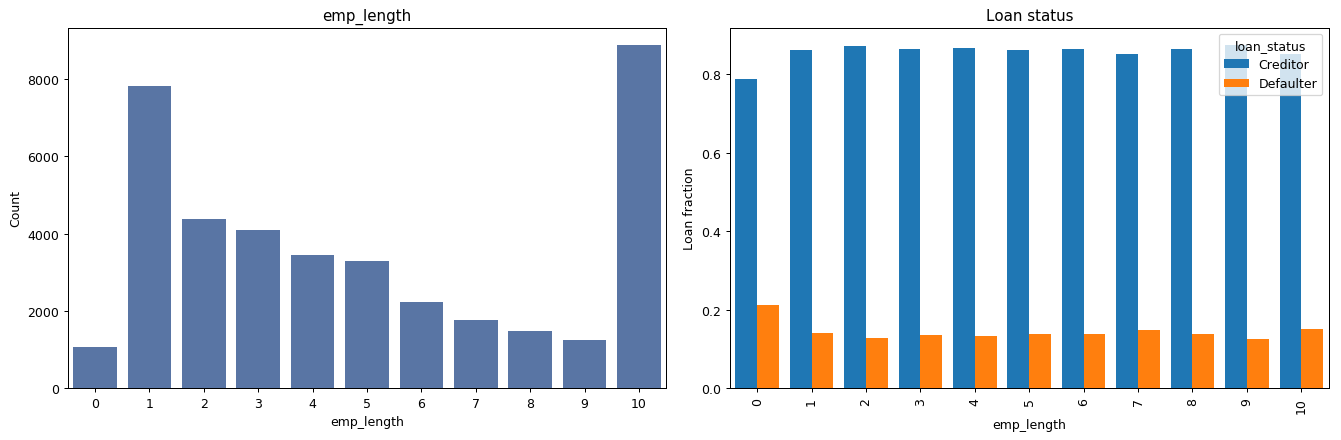

In [0]:
# in the given data 'emp_length' feature have 'NAN' values. so,replace it with 0.

Data.emp_length.fillna(value=0,inplace=True)
Data['emp_length'].replace(to_replace='[^0-9]+', value='', inplace=True, regex=True)

# '[^0-9]+' - RegExp , which search the character other than digits.

Data['emp_length'] = Data['emp_length'].astype(int)
plt_feature('emp_length', False)

From the plot , we get that the Loan status is almost the same throughout the every employment length.so, I can replace it also.

In [0]:
# Feature : home_ownership

Data.home_ownership.value_counts()

RENT        18899
MORTGAGE    17659
OWN          3058
OTHER          98
NONE            3
Name: home_ownership, dtype: int64

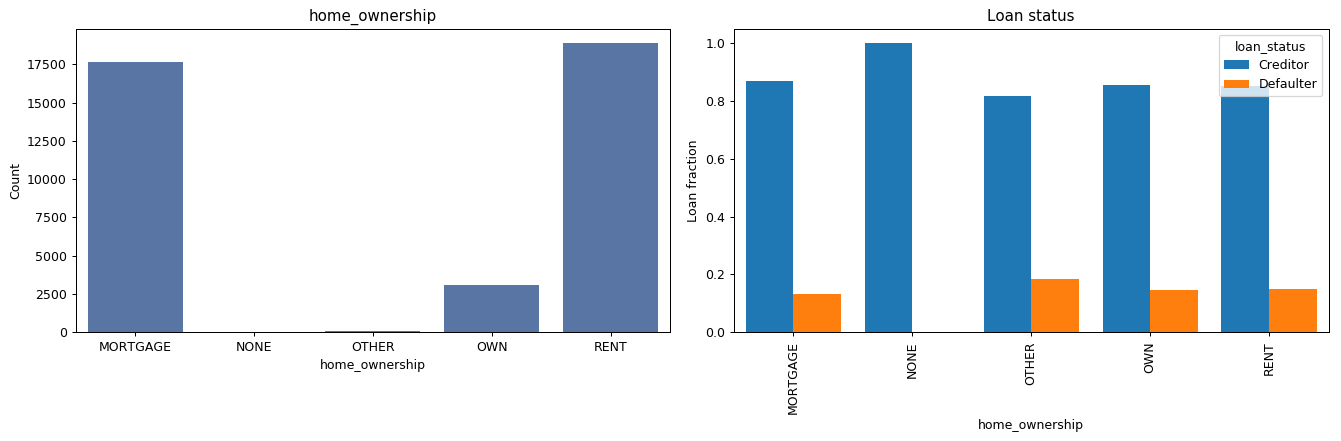

In [0]:
plt_feature('home_ownership',False)

In the plot with loan status , we can clearly visualise that applicant with own house and applicant on rent have same  chance of getting charged off. so, i think home ownership didn't affect the loan status effectively ,but i will keep it for further analysis.

In [0]:
#Feature: annual_inc

len(Data.annual_inc.value_counts())

5318

annual_inc is a self reported annual income provided by the borrower during registration.
so,i think it will play a major role in recognising defaulter.
But here it has long range of value so i will divide it in 5 groups.   
5 :   0 < account_inc < 25000  ;  
4 :   25000 < account_inc < 50000   ;        
3 :   50000 < account_inc < 75000   ;  
2 :   75000 < account_inc < 100000 ;   
1 :      account_inc >100000

So,i will create new feature  '  annual_inc_update  ' and wil remove ' annual_inc '.

In [0]:
Data['annual_inc_update']=Data.annual_inc.map(lambda x : 5 if 0<x<=25000 else ( 4 if 25000<x<=50000 else ( 3  if 50000<x<=75000 else ( 2  if 75000<x<=100000 else  1))))

In [0]:
Data.annual_inc_update.value_counts()

4    13168
3    12027
2     6259
1     5687
5     2576
Name: annual_inc_update, dtype: int64

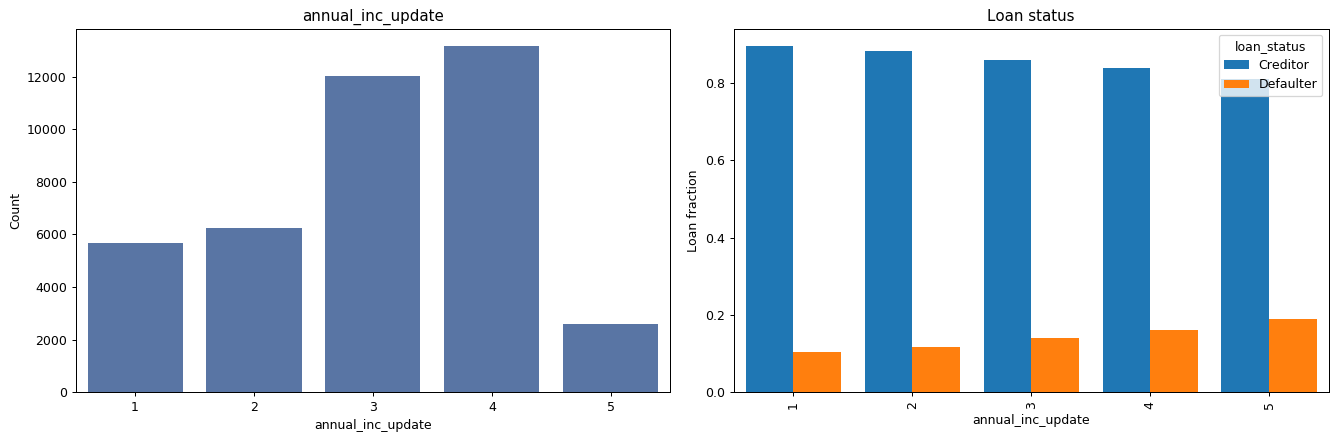

In [0]:
plt_feature('annual_inc_update',False)

As i can easily visualise from the plot with loan status that applicant with lesser annual_inc have more chance to get charged off. 

In [0]:
# now remove the feature which is not important between column with index 7 to 13.
Remove_Feature.extend(['emp_title', 'grade','annual_inc'])

## VISUALISE FEATURES FROM INDEX (14-20):

In [0]:
Data.iloc[0:5, 14: 21]

,verification_status,issue_d,loan_status,url,desc,purpose,title
0,Verified,12/11,Creditor,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/22/11 > I need to upgra...,credit_card,Computer
1,Source Verified,12/11,Defaulter,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/22/11 > I plan to use t...,car,bike
2,Not Verified,12/11,Creditor,https://lendingclub.com/browse/loanDetail.acti...,NaN,small_business,real estate business
3,Source Verified,12/11,Creditor,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/21/11 > to pay for prop...,other,personel
4,Source Verified,12/11,Creditor,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/21/11 > I plan on combi...,other,Personal


In [0]:
# Feature :verification_status

In [0]:
Data.verification_status.value_counts()

Not Verified       16921
Verified           12809
Source Verified     9987
Name: verification_status, dtype: int64

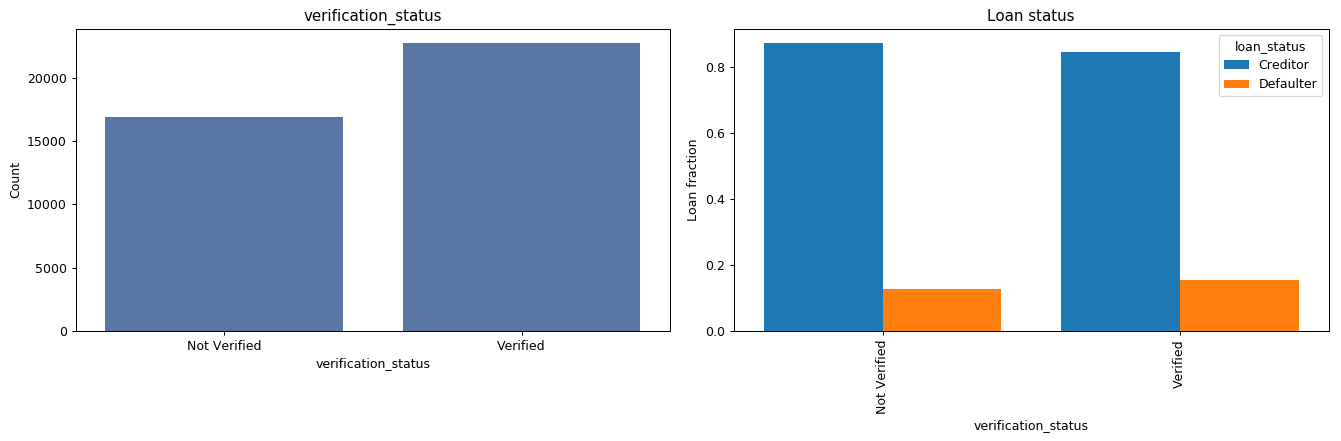

In [0]:
Data.verification_status=Data.verification_status.map(lambda x : 'Not Verified' if x=='Not Verified' else 'Verified')

## i consider 'Verified' and 'Source Verified' as ' Verified ' otherwise ' Not Verified'

plt_feature('verification_status',False)

 From the plot , it is very unusual that the aplicant with verified acount have more chances of geting chargde off.

In [0]:
######

In [0]:
# Feature : Issue_d
Data.issue_d.value_counts()

12/11    2260
11/11    2223
10/11    2114
09/11    2063
08/11    1928
07/11    1870
06/11    1827
05/11    1689
04/11    1562
03/11    1443
01/11    1380
02/11    1297
12/10    1267
10/10    1132
11/10    1121
07/10    1119
09/10    1086
08/10    1078
06/10    1029
05/10     920
04/10     827
03/10     737
02/10     627
11/09     602
12/09     598
01/10     589
10/09     545
09/09     449
08/09     408
07/09     374
06/09     356
05/09     319
04/09     290
03/09     276
02/09     260
01/09     239
03/08     236
12/08     223
11/08     184
02/08     174
01/08     171
04/08     155
10/08      96
12/07      85
07/08      83
05/08      71
08/08      71
06/08      66
10/07      47
11/07      37
08/07      33
09/08      32
07/07      30
09/07      18
06/07       1
Name: issue_d, dtype: int64

We are dealing with four year of Data ,so i will only extract month and visualise about how the loan issue month affect the loan status

In [0]:
Data['issue_month'], Data['issue_year'] = Data['issue_d'].str.split('/', 1).str

In [0]:
Data.issue_month.value_counts()

12    4433
11    4167
10    3934
09    3648
08    3518
07    3476
06    3279
05    2999
04    2834
03    2692
01    2379
02    2358
Name: issue_month, dtype: int64

In [0]:
Data.issue_year.value_counts()

11    21656
10    11532
09     4716
08     1562
07      251
Name: issue_year, dtype: int64

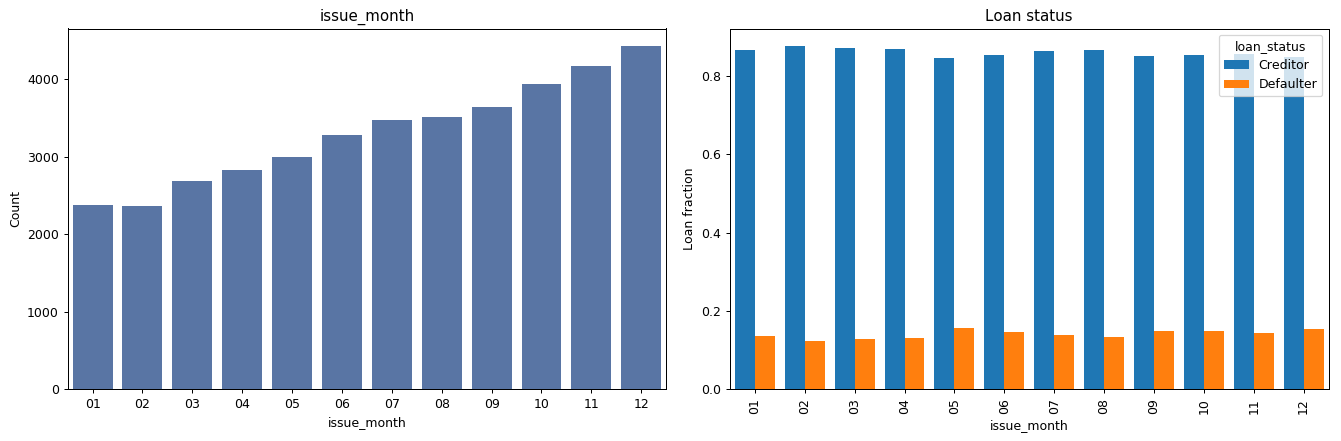

In [0]:
plt_feature('issue_month',False)

From the plot it look like issuing month does not affect loan status effectively.but i will keep it for further analysis.

In [0]:
##feature: URL

I think URL has nothing to do with Loan status. so, i will remove it.

In [0]:
## feature : desc 

it is the loan description provided by the borrower,  but none of the case have  complete decsription .so, i will remove it.


In [0]:
#Feature : purpose
Data.purpose.value_counts()


debt_consolidation    18641
credit_card            5130
other                  3993
home_improvement       2976
major_purchase         2187
small_business         1828
car                    1549
wedding                 947
medical                 693
moving                  583
vacation                381
house                   381
educational             325
renewable_energy        103
Name: purpose, dtype: int64

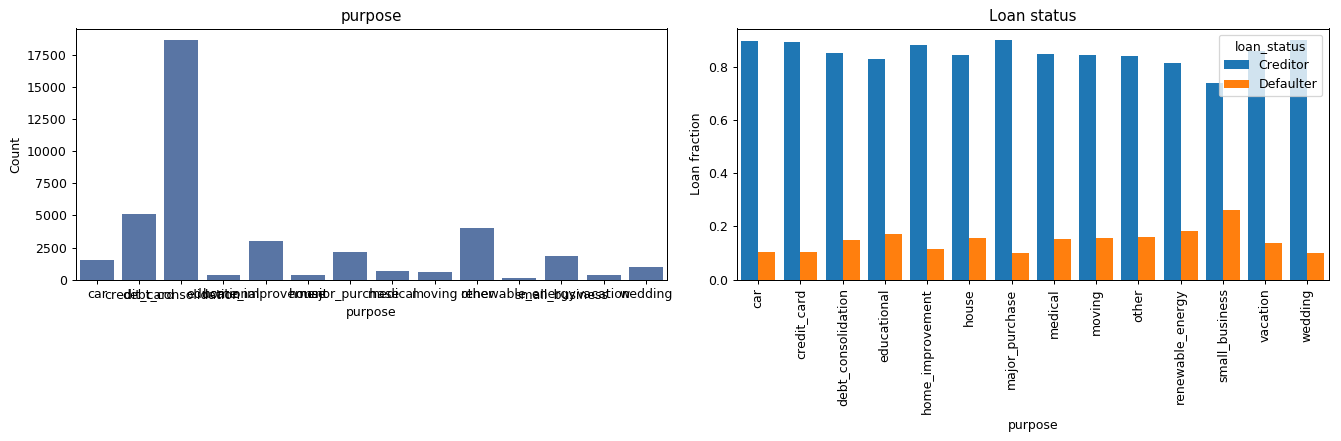

In [0]:
plt_feature('purpose',False)

From the plot with loan status ,it can be visualise that 'purpose' willbe useful feature to recognise a defaulter.
As people who borrowed loan for small_bussiness and renewable energy are more likely to be a Defaulter.

In [0]:
#Feature : title

len(Data.title.value_counts())

19613

since the feature 'title'   have lot of unique value,i will simply remove it. 

In [0]:
# now remove the feature which is not important between column with index 14 to 20.
Remove_Feature.extend(['url', 'issue_d','desc','title'])

## VISUALISE FEATURES FROM INDEX (21-27):

In [0]:
Data.iloc[0:5, 21:28]

,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq
0,860xx,AZ,27.65,0,01/85,1,NaN
1,309xx,GA,1,0,04/99,5,NaN
2,606xx,IL,8.72,0,11/01,2,NaN
3,917xx,CA,20,0,02/96,1,35
4,972xx,OR,17.94,0,01/96,0,38


In [0]:
##Feature: zip_code

len(Data.zip_code.value_counts())

823

Since the feature 'zip_code' have lot of unique value. so, i will simply remove it.

In [0]:
# Feature : addr_state


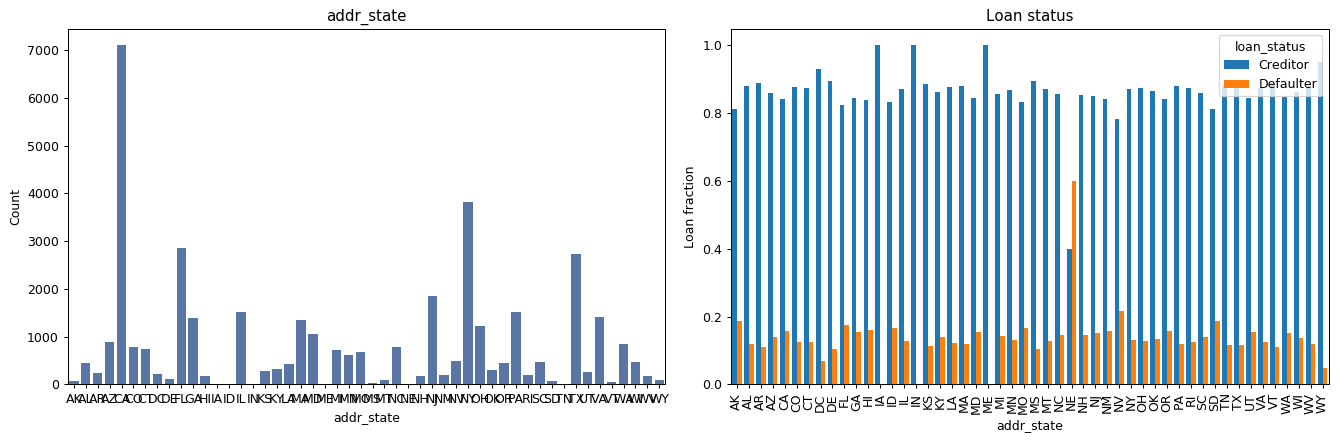

In [0]:
plt_feature('addr_state',False)

From the plot it  can be easily visualise that some state have more defaulter  applicant than other. therefore , this feature can be discriminatory.

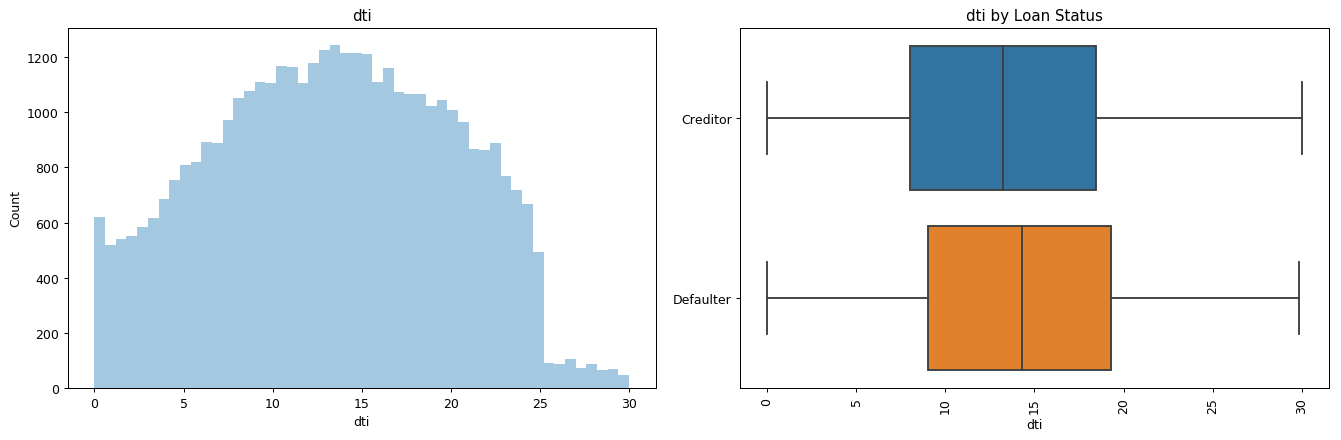

In [0]:
# feature : dti
Data.dti=Data.dti.astype(float)
plt_feature('dti',True)

'dti' is the borrower’s total monthly debt payments on the total debt obligations excluding 
requested LC loan, from plot we can keep it for further analysis, as defaulter fraction are for higher dti.

In [0]:
# feature : delinq_2yrs

len(Data.delinq_2yrs.value_counts())

11

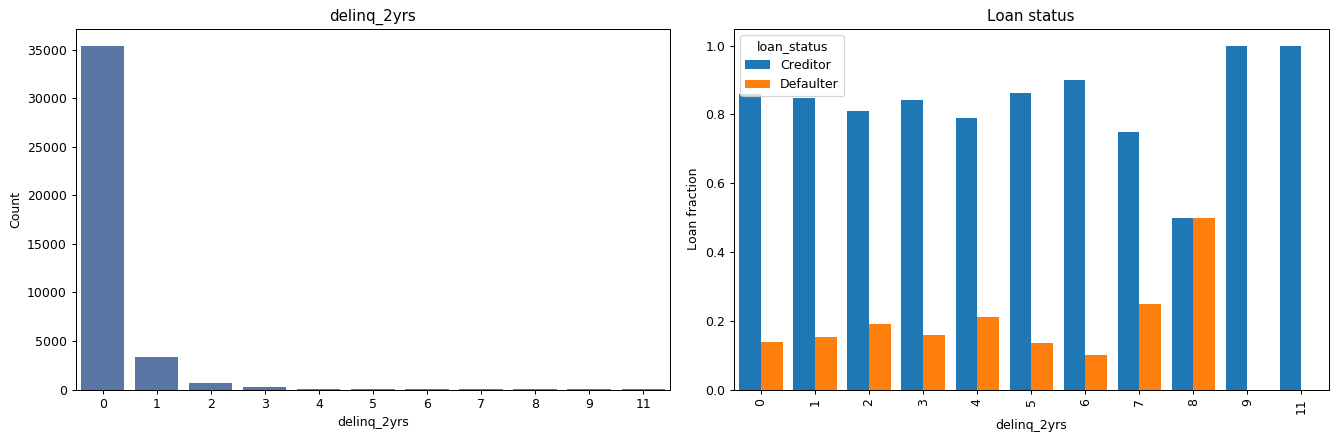

In [0]:
plt_feature('delinq_2yrs',False)

From the plot without loan status it can be visualise that this feature have most of the value is 0. so i think it will not contribute that much.so,i will remove it.

In [0]:
#Feature : earliest_cr_line
#it is the month the borrower's earliest reported credit line was opened .

#earliest_cr_line can be converted to an integer that represents the years since that date,
#which would be more useful for modeling later.

#define a new feature i.e. earliest_cr_year


_,Data['earliest_cr_year'] = Data['earliest_cr_line'].str.split('/', 1).str


In [0]:
len(Data.earliest_cr_year.value_counts())

53

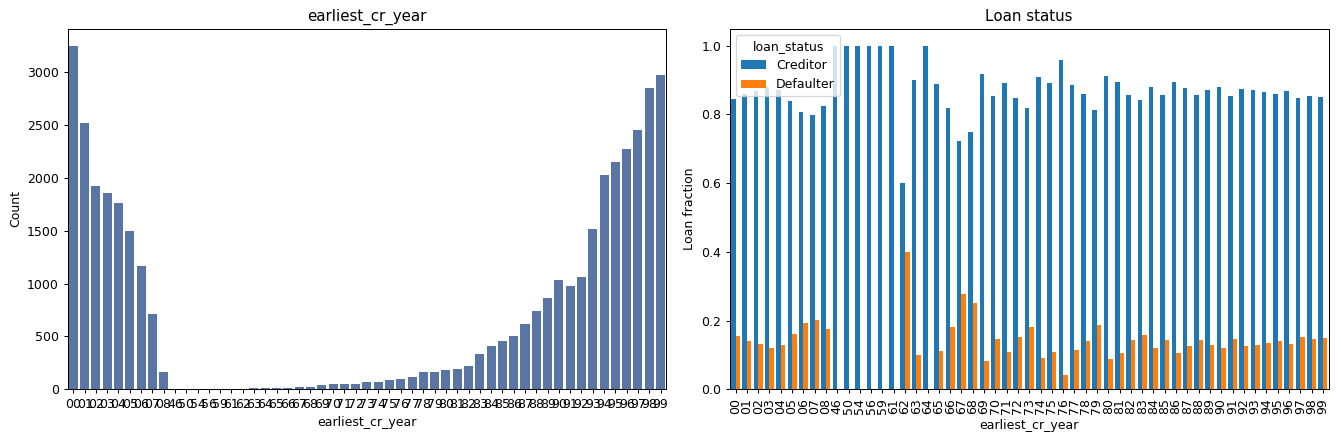

In [0]:
plt_feature('earliest_cr_year',False)

In [0]:
# feature : inq_last_6mths


len(Data.inq_last_6mths.value_counts())

9

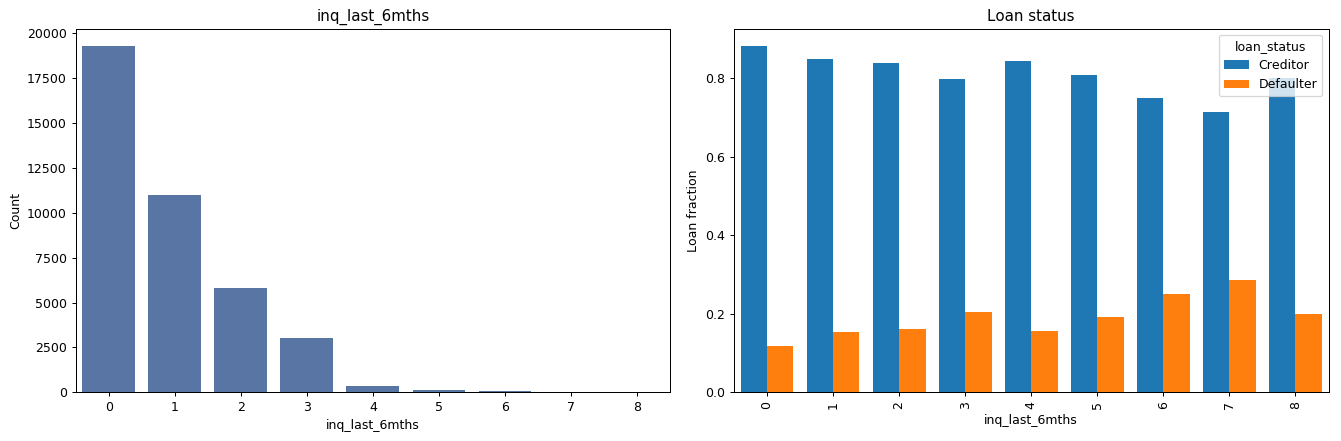

In [0]:
plt_feature('inq_last_6mths',False)

'inq_last_6mths'  is The number of inquiries in past 6 months (excluding auto and mortgage inquiries). From plot with loan_status it can be easily visualise that this feature can be usefull due to of it discriminatory nature.

In [0]:
# Feature : mths_since_last_delinq
len(Data. mths_since_last_delinq.value_counts())

95

 mths_since_last_delinq feature is a categorical feature but it has lot of category . so , i will remove it.

In [0]:
# now remove the feature which is not important between column with index 14 to 20.
Remove_Feature.extend(['mths_since_last_delinq', 'delinq_2yrs','zip_code'])

## VISUALISE FEATURES FROM INDEX (28-34):

In [0]:
Data.iloc[0:5, 28: 35]

,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv
0,3,0,13648,83.70%,9,0,0
1,3,0,1687,9.40%,4,0,0
2,2,0,2956,98.50%,10,0,0
3,10,0,5598,21%,37,0,0
4,15,0,27783,53.90%,38,524.06,524.06


In [0]:
# feature 
#open_acc	: The number of open credit lines in the borrower's credit file.
#pub_rec  :Number of derogatory public records
#revol_bal:Total credit revolving balance
#revol_util:Revolving line utilization rate,or the amount of 
#credit the borrower is using relative to all available revolving credit.



     These are the features which is directly related to loan status.so, i think these features will be usefull for further process.

In [0]:
#Feature : revol_util
# remove the '%' sign ,so as to consider it as integer.

Data['revol_util']=Data['revol_util'].astype(str).str.replace('%', ' ').astype(np.float32)

##It is  the amount of credit the borrower is using relative to all available revolving credit.

In [0]:
Data. total_acc.value_counts()

16    1471
15    1462
17    1457
14    1445
20    1428
18    1422
21    1412
13    1385
19    1341
12    1325
22    1302
11    1278
24    1259
23    1252
10    1193
25    1160
27    1088
9     1080
26    1058
8     1006
28     971
29     931
30     870
7      828
32     794
31     793
6      683
33     647
34     632
35     575
      ... 
54      70
55      54
56      48
57      43
61      42
59      39
62      38
58      33
60      28
64       5
2        4
66       4
67       4
65       3
75       2
79       2
76       2
87       1
81       1
80       1
78       1
77       1
73       1
74       1
72       1
71       1
70       1
69       1
68       1
90       1
Name: total_acc, Length: 82, dtype: int64

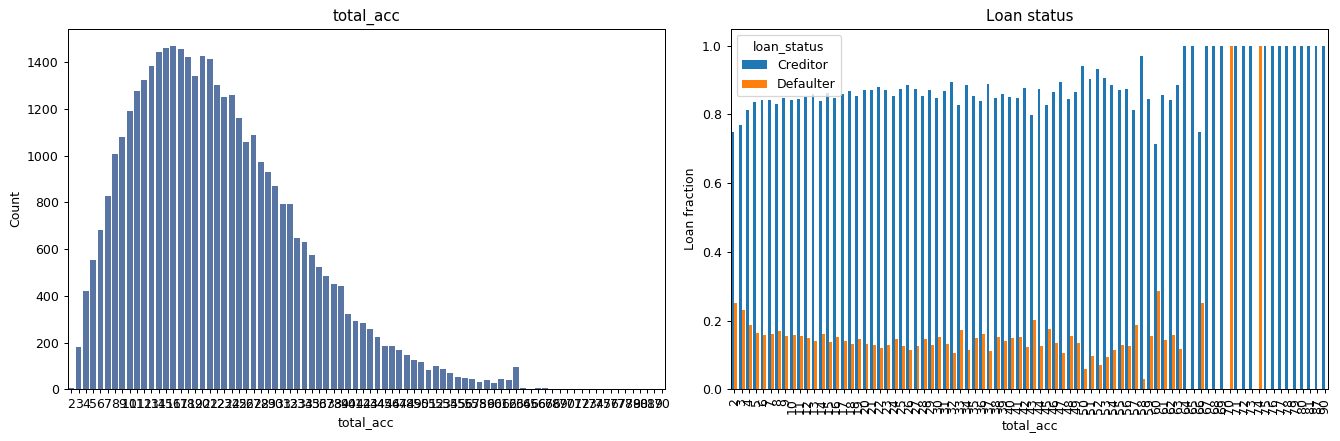

In [0]:
plt_feature('total_acc',False)

### ' total_acc '   feature is not seem to be that much effective as in plot with loan status it has approximately same fraction of defaulter throughout the whole dataset ,except at some point have higher fraction of defaulter but on comparing the two plots these defaulter are for very less number of applicant. so,i wil remove it.

In [0]:
# now remove the feature which is not important between column with index 14 to 20.
Remove_Feature.extend(['total_acc', 'out_prncp','out_prncp_inv'])

## VISUALISE FEATURES FROM INDEX (35-48):

In [0]:
Data.iloc[0:5, 35: 49]

,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,collections_12_mths_ex_med,pub_rec_bankruptcies,tax_liens,annual_inc_update
0,5863.16,5833.84,5000,863.16,0,0,0,01/15,171.62,05/16,0,0,0,5
1,1008.71,1008.71,456.46,435.17,0,117.08,1.11,04/13,119.66,09/13,0,0,0,4
2,3005.67,3005.67,2400,605.67,0,0,0,06/14,649.91,05/16,0,0,0,5
3,12231.9,12231.9,10000,2214.92,16.97,0,0,01/15,357.48,04/16,0,0,0,4
4,3513.33,3513.33,2475.94,1037.39,0,0,0,05/16,67.79,05/16,0,0,0,2


In [0]:
#Feature: annual_inc_update
Data.annual_inc_update.value_counts()

4    13168
3    12027
2     6259
1     5687
5     2576
Name: annual_inc_update, dtype: int64

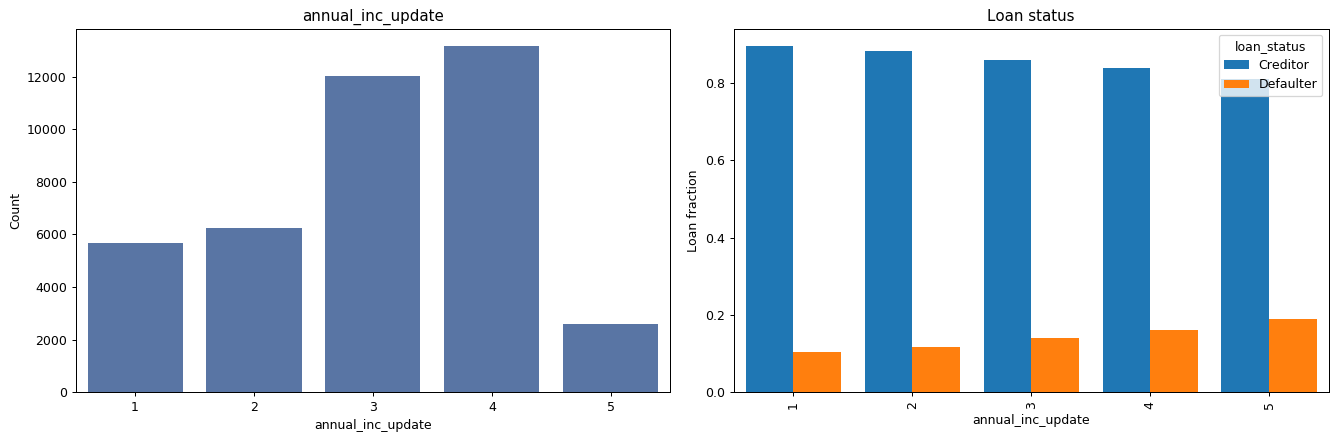

In [0]:
plt_feature('annual_inc_update',False)

In [0]:
#feature: tax_liens
Data.	tax_liens.value_counts()

0.0    39678
Name: tax_liens, dtype: int64

i will remove 'tax_liens ' as it has unique value for most of the example.

In [0]:
# Feature: pub_rec_bankruptcies
Data.	pub_rec_bankruptcies.value_counts()

0.0    37339
1.0     1674
2.0        7
Name: pub_rec_bankruptcies, dtype: int64

In this case also lots of example are for only 0.so, i will  remove it as it will not a discriminatory feature to identify defaulter.

In [0]:
# now remove the feature which is not important between column with index 35 to 48.
Remove_Feature.extend(['total_pymnt','total_pymnt_inv','total_rec_prncp','total_rec_int','total_rec_late_fee','recoveries','collection_recovery_fee', 'last_pymnt_d', 
                               'last_pymnt_amnt','collections_12_mths_ex_med','earliest_cr_line','last_credit_pull_d','tax_liens','pub_rec_bankruptcies'])

In [0]:
len(set(Remove_Feature))

28

In [0]:
print(Remove_Feature)

['member_id', 'emp_title', 'grade', 'annual_inc', 'url', 'issue_d', 'desc', 'title', 'mths_since_last_delinq', 'delinq_2yrs', 'zip_code', 'total_acc', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', 'collections_12_mths_ex_med', 'earliest_cr_line', 'last_credit_pull_d', 'tax_liens', 'pub_rec_bankruptcies']


In [0]:
#Remove these features 
new_Data=pd.DataFrame()
new_Data=Data.drop(list(set(Remove_Feature)), axis = 1)


In [0]:
new_Data.shape

(39717, 24)

In [0]:
new_Data.head()

,s,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,sub_grade,emp_length,home_ownership,verification_status,loan_status,purpose,addr_state,dti,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,annual_inc_update,issue_month,issue_year,earliest_cr_year
0,1077501,5000.0,5000,4975,36 months,10.65,162.87,B2,10,RENT,Verified,Creditor,credit_card,AZ,27.65,1,3,0,13648,83.699997,5,12,11,85
1,1077430,2500.0,2500,2500,60 months,15.27,59.83,C4,1,RENT,Verified,Defaulter,car,GA,1.00,5,3,0,1687,9.400000,4,12,11,99
2,1077175,2400.0,2400,2400,36 months,15.96,84.33,C5,10,RENT,Not Verified,Creditor,small_business,IL,8.72,2,2,0,2956,98.500000,5,12,11,01
3,1076863,10000.0,10000,10000,36 months,13.49,339.31,C1,10,RENT,Verified,Creditor,other,CA,20.00,1,10,0,5598,21.000000,4,12,11,96
4,1075358,3000.0,3000,3000,60 months,12.69,67.79,B5,1,RENT,Verified,Creditor,other,OR,17.94,0,15,0,27783,53.900002,2,12,11,96


In [0]:
# remove the 'months' string from 'term' feature to make it a numeical value.

new_Data.term = new_Data.term.str.replace('months','').astype(np.float32)

Now we have to encode the categorical features.

In [0]:
# encoding of string value in loan_status to a numerical value. 
new_Data.loan_status=new_Data.loan_status.map(lambda x : 1.0 if x== 'Defaulter' else 0.0)

In [0]:
new_Data.purpose = new_Data.purpose.astype("category", categories=np.unique(new_Data.purpose)).cat.codes
new_Data.home_ownership = new_Data.home_ownership.astype("category", categories = np.unique(new_Data.home_ownership)).cat.codes
new_Data.sub_grade = new_Data.sub_grade.astype("category", categories = np.unique(new_Data.sub_grade)).cat.codes
new_Data.addr_state = new_Data.addr_state.astype("category", categories = np.unique(new_Data.addr_state)).cat.codes
new_Data.verification_status = new_Data.	verification_status.astype("category", categories = np.unique(new_Data.	verification_status)).cat.codes

In [0]:
new_Data.head()

,s,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,sub_grade,emp_length,home_ownership,verification_status,loan_status,purpose,addr_state,dti,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,annual_inc_update,issue_month,issue_year,earliest_cr_year
0,1077501,5000.0,5000,4975,36.0,10.65,162.87,6,10,4,1,0.0,1,3,27.65,1,3,0,13648,83.699997,5,12,11,85
1,1077430,2500.0,2500,2500,60.0,15.27,59.83,13,1,4,1,1.0,0,10,1.00,5,3,0,1687,9.400000,4,12,11,99
2,1077175,2400.0,2400,2400,36.0,15.96,84.33,14,10,4,0,0.0,11,14,8.72,2,2,0,2956,98.500000,5,12,11,01
3,1076863,10000.0,10000,10000,36.0,13.49,339.31,10,10,4,1,0.0,9,4,20.00,1,10,0,5598,21.000000,4,12,11,96
4,1075358,3000.0,3000,3000,60.0,12.69,67.79,9,1,4,1,0.0,9,36,17.94,0,15,0,27783,53.900002,2,12,11,96


##  EXPLORATORY ANALYSIS OF SELECTED FEATURES

Now i am going find the relation between different features which is one of the way identify bad and collinear features.

In [0]:
new_Data = new_Data[new_Data.columns].astype(float) # change all the feature to type float.

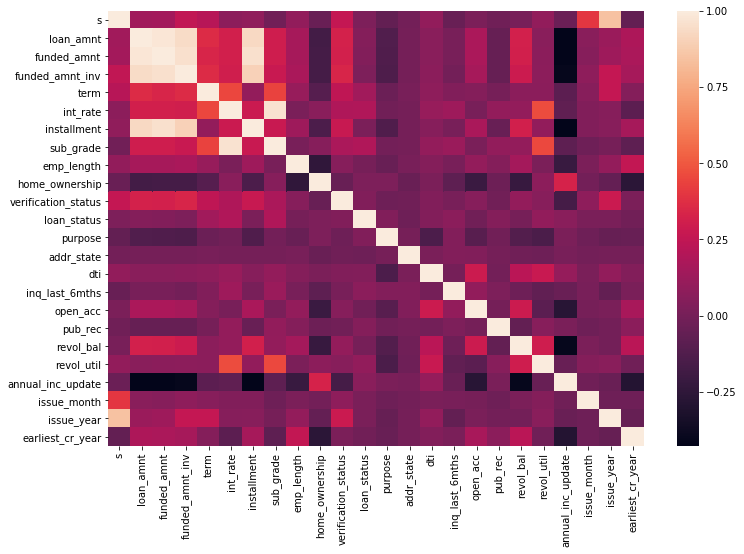

In [0]:
rel = new_Data.corr()
plt.figure(figsize = (12, 8))
sns.heatmap(rel,xticklabels=True, yticklabels=True)
plt.show()

this heatmap is very difficult to visualise clearly. so,i will plot a specific plot related to my target variable.

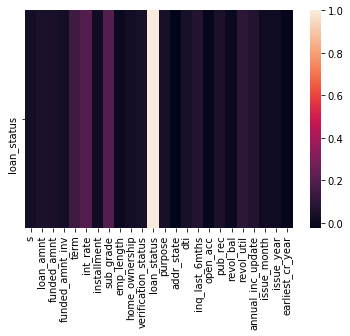

In [0]:
sns.heatmap(new_Data.corr().loc[['loan_status'],:])

Numerical represantation of above plot is shown below.

In [0]:

new_Data.corr().loc['loan_status',:].sort_values(ascending = False)

loan_status            1.000000
int_rate               0.196253
sub_grade              0.193660
term                   0.146038
revol_util             0.096560
inq_last_6mths         0.071717
annual_inc_update      0.068075
pub_rec                0.050880
loan_amnt              0.048217
funded_amnt            0.045544
dti                    0.041701
purpose                0.041068
verification_status    0.037280
s                      0.028370
funded_amnt_inv        0.026621
home_ownership         0.025494
installment            0.022589
issue_month            0.017561
issue_year             0.014997
emp_length             0.004037
revol_bal              0.003369
open_acc              -0.010742
earliest_cr_year      -0.012265
addr_state            -0.024128
Name: loan_status, dtype: float64

From the above we can easily understand that earliest_cr_year  and addr_state  have highly negative correlation with loan_status.
so,iam going to remove 'earliest_cr_year'  and 'addr_state'  both.

In [0]:
new_Data.drop(['earliest_cr_year','addr_state'], axis=1, inplace=True)

In [0]:
corr_matrix = new_Data.corr().abs()

#the matrix is symmetric so we need to extract upper triangle matrix without diagonal (k = 1)
sol = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
                 .stack()
                 .sort_values(ascending=False))

In [0]:
sol

loan_amnt            funded_amnt            0.981578
int_rate             sub_grade              0.961573
funded_amnt          funded_amnt_inv        0.958422
                     installment            0.956159
loan_amnt            funded_amnt_inv        0.940034
                     installment            0.930288
funded_amnt_inv      installment            0.905039
s                    issue_year             0.846269
int_rate             revol_util             0.467168
sub_grade            revol_util             0.455476
term                 int_rate               0.451699
                     sub_grade              0.441739
loan_amnt            annual_inc_update      0.426939
installment          annual_inc_update      0.423912
funded_amnt          annual_inc_update      0.422797
revol_bal            annual_inc_update      0.405931
funded_amnt_inv      annual_inc_update      0.405021
s                    issue_month            0.401693
loan_amnt            term                   0.

there is no such feature which is 100% correlated with other . 
loan_amnt  and funded_amnt  are  highly correlated but  only 98%.so,i will keep both of them.

#2.MODEL BUILDING

## Now , it's time for machine learning algorithms to make predictive model ,so that we can easily eastimate the risk of a financial decision.

###But firstly , i have to find whether the features have categorical or continuous value.

In [0]:
column_list=new_Data.columns
len(column_list)

22

In [0]:
column_list

Index(['s', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
       'installment', 'sub_grade', 'emp_length', 'home_ownership',
       'verification_status', 'loan_status', 'purpose', 'dti',
       'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util',
       'annual_inc_update', 'issue_month', 'issue_year'],
      dtype='object')

In [0]:
for i in range(22):
  print(column_list[i] ,':' , len(new_Data.iloc[:,i].value_counts()))

s : 39717
loan_amnt : 885
funded_amnt : 1041
funded_amnt_inv : 8205
term : 2
int_rate : 371
installment : 15383
sub_grade : 35
emp_length : 11
home_ownership : 5
verification_status : 2
loan_status : 2
purpose : 14
dti : 2868
inq_last_6mths : 9
open_acc : 40
pub_rec : 5
revol_bal : 21711
revol_util : 1089
annual_inc_update : 5
issue_month : 12
issue_year : 5


## About half of the features have unique value less than 15,which means most of the feature are categorical.Therefore , i will start with a tree-based algorithm.

# Data Balancing

unequal number of data in different classes i.e.
data is unbalanced

In [0]:
new_Data.loan_status.value_counts(normalize=True)

0.0    0.858323
1.0    0.141677
Name: loan_status, dtype: float64

The above result show that the dataset is imbalance,
where '' charged off ' is a minority class and consists of 14.2% of the entire examples

In [0]:
new_Data.loan_status.value_counts()

0.0    34090
1.0     5627
Name: loan_status, dtype: int64

Machine learning models will learn it's parameter mostly based on the classes with more examples.
so, the model would be biased towards majority class.
To solve this problem i will use Resampling technique.

now i will separate the dataset in two parts of 'Data_major ' and ' Data_ minor '

In [0]:
# IMPORTING resample
from sklearn.utils import resample 

In [0]:
Data_major =new_Data[new_Data.loan_status == 0]
Data_minor =new_Data[new_Data.loan_status == 1]
Data_minor_upsmapled = resample(Data_minor, replace = True, n_samples = 34090, random_state = 1)
Data_minor_upsmapled = pd.concat([Data_minor_upsmapled, Data_major])  # finaldata after concatenation.
Data_minor_upsmapled.loan_status.value_counts()

0.0    34090
1.0    34090
Name: loan_status, dtype: int64

To check if there is any NaN value.

In [0]:
Data_minor_upsmapled[pd.isnull(Data_minor_upsmapled).any(axis=1)]

,s,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,sub_grade,emp_length,home_ownership,verification_status,loan_status,purpose,dti,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,annual_inc_update,issue_month,issue_year
25977,576386.0,3200.0,3200.0,3200.000000,36.0,17.930000,115.58,24.0,5.0,4.0,1.0,1.0,2.0,11.85,0.0,2.0,0.0,0.0,NaN,5.0,9.0,10.0
26813,562958.0,2100.0,2100.0,2100.000000,36.0,15.210000,73.02,16.0,1.0,4.0,0.0,1.0,4.0,20.33,2.0,2.0,0.0,0.0,NaN,5.0,8.0,10.0
38457,353677.0,7500.0,7500.0,0.002284,36.0,16.330000,264.91,26.0,6.0,0.0,0.0,1.0,1.0,10.80,0.0,4.0,0.0,0.0,NaN,4.0,8.0,8.0
29236,524545.0,1500.0,1500.0,1500.000000,36.0,16.820000,53.35,21.0,8.0,4.0,0.0,1.0,2.0,13.05,2.0,2.0,0.0,0.0,NaN,4.0,6.0,10.0
29236,524545.0,1500.0,1500.0,1500.000000,36.0,16.820000,53.35,21.0,8.0,4.0,0.0,1.0,2.0,13.05,2.0,2.0,0.0,0.0,NaN,4.0,6.0,10.0
37911,369400.0,5000.0,5000.0,4250.000000,36.0,18.209999,181.30,28.0,1.0,0.0,1.0,1.0,2.0,11.39,3.0,3.0,0.0,0.0,NaN,4.0,12.0,8.0
26813,562958.0,2100.0,2100.0,2100.000000,36.0,15.210000,73.02,16.0,1.0,4.0,0.0,1.0,4.0,20.33,2.0,2.0,0.0,0.0,NaN,5.0,8.0,10.0
26813,562958.0,2100.0,2100.0,2100.000000,36.0,15.210000,73.02,16.0,1.0,4.0,0.0,1.0,4.0,20.33,2.0,2.0,0.0,0.0,NaN,5.0,8.0,10.0
12042,804073.0,3000.0,3000.0,3000.000000,60.0,22.110001,83.05,30.0,6.0,3.0,1.0,1.0,9.0,0.00,0.0,3.0,0.0,0.0,NaN,5.0,7.0,11.0
38457,353677.0,7500.0,7500.0,0.002284,36.0,16.330000,264.91,26.0,6.0,0.0,0.0,1.0,1.0,10.80,0.0,4.0,0.0,0.0,NaN,4.0,8.0,8.0


Remove above 125 rows that have NaN values

In [0]:
Data_minor_upsampled_final=Data_minor_upsmapled.dropna() #remove these 125 rows hich contains NaN

In [0]:
Data_minor_upsampled_final.shape

(68055, 22)

now they are balance

now it's time for the :

# Dtata standardization

###In the Dataset the range of values for different feature varies on a very different range . So , i will standardised every feature to make their range same.

but before we have to spit the dataset into feature  and target set.



In [0]:
X = Data_minor_upsampled_final.drop('loan_status', axis = 1)
Y = Data_minor_upsampled_final.loan_status
xtrain, xtest, ytrain, ytest = train_test_split(X, Y, test_size=0.2, random_state=0)
xtrain_scaled = StandardScaler().fit_transform(xtrain.values)


Our Data is ready to use for making prediction.

Now i will use Logistic Regression as first model  as this model is relatively simple and easy to implement .

In [0]:
from sklearn.linear_model import LogisticRegression  # import LogisticRegression 

model_L_R=LogisticRegression()
model_L_R.fit(xtrain_scaled,ytrain)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

Now it's time fo prediction but before that i have to standardised the test dataset.

In [0]:
xtest_scaled = StandardScaler().fit_transform(xtest.values)
pred_L_R = model_L_R.predict(xtest_scaled)

In [0]:
def evaluate_model(ytest, ypred):
    
    print('Accuracy of the model: {}\n'.format(accuracy_score(ytest, ypred)))
    print('Classification report: \n{}\n'.format(classification_report(ytest, ypred)))
    print('Confusion matrix: \n{}\n'.format(confusion_matrix(ytest, ypred)))


In [0]:
evaluate_model(ytest, pred_L_R)

Accuracy of the model: 0.6374990816251561

Classification report: 
              precision    recall  f1-score   support

         0.0       0.64      0.64      0.64      6896
         1.0       0.63      0.64      0.63      6715

    accuracy                           0.64     13611
   macro avg       0.64      0.64      0.64     13611
weighted avg       0.64      0.64      0.64     13611


Confusion matrix: 
[[4391 2505]
 [2429 4286]]



In [0]:
from sklearn.metrics import roc_curve ,auc
def ROC_model(model,test_X,test_Y,cols=None):
    fig = plt.figure(figsize=(10,8))
    ax  = fig.add_subplot(111)
# cols=Data_minor_upsmapled.columns
    prediction_probabilities = model.predict_proba(test_X)[:,1]
    fpr , tpr , thresholds   = roc_curve(test_Y,prediction_probabilities)
    ax.plot(fpr,tpr,label   = ["Area under curve : ",auc(fpr,tpr)],linewidth=2,linestyle="dotted")
    ax.plot([0,1],[0,1],linewidth=2,linestyle="dashed")
    plt.legend(loc="best")
    plt.title("ROC-CURVE & AREA UNDER CURVE")
    ax.set_facecolor("k")

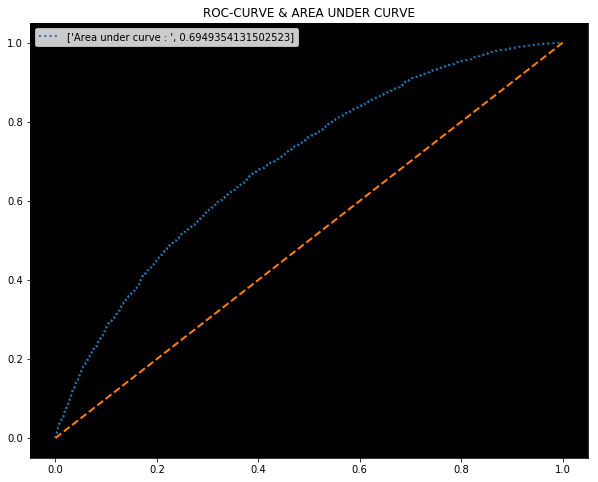

In [0]:
ROC_model(model_L_R,xtest_scaled,ytest)

By using Logistic Regression , we got 63% accuracy this is not the accuracy that i want but it is good accuracy for such a simple model llike Logistic Regression.so,it's a good start.

## 2 . Random forest model

In [0]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=150, max_depth=50,random_state=0)
clf.fit(xtrain_scaled,ytrain)
pred_RF=clf.predict(xtest_scaled)

In [0]:
evaluate_model(ytest, pred_RF)

Accuracy of the model: 0.9826610829476159

Classification report: 
              precision    recall  f1-score   support

         0.0       0.99      0.97      0.98      6896
         1.0       0.97      0.99      0.98      6715

    accuracy                           0.98     13611
   macro avg       0.98      0.98      0.98     13611
weighted avg       0.98      0.98      0.98     13611


Confusion matrix: 
[[6720  176]
 [  60 6655]]



Wow! , thats 98% but this much jump from 63% to 98% is a bit suspecting.
So, to check the robustness of the model ,i will check the performance of the model on different folds by using sklearn cross-validation method.

In [0]:
from sklearn.model_selection import cross_validate, KFold

In [0]:
scoring =  ['accuracy','recall','roc_auc','f1']


In [0]:
scores = cross_validate(clf, X = xtrain_scaled, y = ytrain, scoring = scoring, cv = 10, return_train_score = False, verbose = 10, n_jobs= -1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   46.2s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.9min finished


In [0]:
scores

{'fit_time': array([21.90669131, 21.95521188, 21.77089977, 21.95685625, 21.85450745,
        21.848593  , 21.85237575, 21.83841062, 22.1239531 , 22.21034479]),
 'score_time': array([1.1314857 , 1.13999653, 1.11918831, 1.124475  , 1.11391044,
        1.12582445, 1.1413641 , 1.14153218, 1.12075138, 1.04421735]),
 'test_accuracy': array([0.97759412, 0.97869605, 0.97924702, 0.97630854, 0.97795738,
        0.97961058, 0.98126378, 0.97538575, 0.97703894, 0.97703894]),
 'test_f1': array([0.9778745 , 0.97884756, 0.97948811, 0.97658377, 0.97816594,
        0.97982918, 0.98147475, 0.97571584, 0.97726859, 0.97740011]),
 'test_recall': array([0.98790766, 0.98351044, 0.98864053, 0.98570905, 0.98533724,
        0.98826979, 0.99046921, 0.98680352, 0.98497067, 0.99083578]),
 'test_roc_auc': array([0.99593057, 0.99277209, 0.99559975, 0.99397231, 0.99500199,
        0.99538003, 0.99754233, 0.99600958, 0.99526349, 0.99723157])}

From the above table , it is performing consistently across the folds and hence robust.

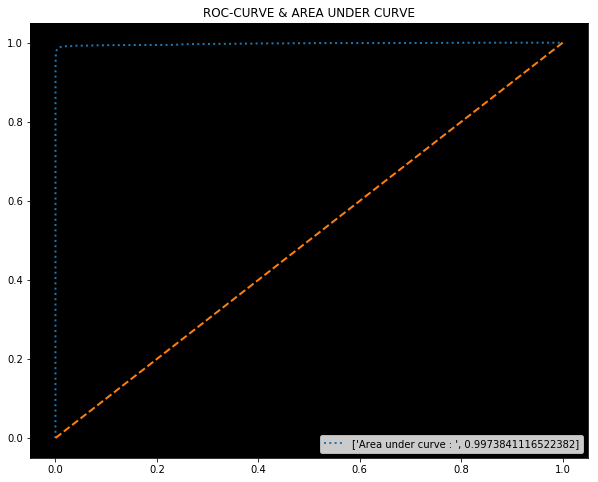

In [0]:
ROC_model(clf,xtest_scaled,ytest)

## LightGBM Model

By using Random Forest , it gives 98% accuracy for the model which is a very good accuracy .
But i have good option to check it's performance on other model.

In [0]:
import lightgbm
lgb=lightgbm.LGBMClassifier(n_estimators= 6000,max_depth=120,objective='binary',learning_rate=0.02,num_leaves= 250,feature_fraction=0.64,bagging_fraction= 0.8,bagging_freq=1,boosting_type= 'gbdt')
lgb.fit(xtrain_scaled, ytrain)
pred_lgb=lgb.predict(xtest_scaled)

In [0]:
evaluate_model(ytest, pred_lgb)

Accuracy of the model: 0.9825876129601058

Classification report: 
              precision    recall  f1-score   support

         0.0       0.99      0.97      0.98      6896
         1.0       0.97      0.99      0.98      6715

    accuracy                           0.98     13611
   macro avg       0.98      0.98      0.98     13611
weighted avg       0.98      0.98      0.98     13611


Confusion matrix: 
[[6704  192]
 [  45 6670]]



From this model also we get approximately 98% accuracy.

In real world , data is uncleaned and full of null values . It will take us lots of time to do feature analysis and decide which column should be dropped.
And finally the predictive model is ready for the analysis and recogning a defaulter.

Thanks!!